In [1]:
!pip install -U -q kaggl!mkdir /root/.kaggle
!echo '{"username":"sukhada11","key":"0d69732f7889957dabb8fff9001dcf58"}' > /root/.kaggle/kaggle.json

IndentationError: ignored

In [2]:
import os
os.environ['KAGGLEUSERNAME'] = "sukhada11" # username from the json file
os.environ['KAGGLEKEY'] = "0d69732f7889957dabb8fff9001dcf58" # key from the json file
!kaggle competitions download -c padhai-hindi-vowel-consonant-classification --force

  0% 0.00/145k [00:00<?, ?B/s]
100% 145k/145k [00:00<00:00, 41.9MB/s]
 93% 85.0M/91.3M [00:00<00:00, 47.2MB/s]
100% 91.3M/91.3M [00:00<00:00, 99.1MB/s]
 91% 83.0M/91.3M [00:00<00:00, 54.9MB/s]
100% 91.3M/91.3M [00:00<00:00, 125MB/s] 


In [8]:
#! mkdir train
! unzip train.zip -d train



Archive:  train.zip
   creating: train/train/
  inflating: train/train/V0_C0_25.png  
  inflating: train/train/V0_C2_18.png  
  inflating: train/train/V0_C2_36.png  
  inflating: train/train/V0_C4_22.png  
  inflating: train/train/V0_C6_34.png  
  inflating: train/train/V0_C6_41.png  
  inflating: train/train/V0_C6_43.png  
  inflating: train/train/V2_C5_87.png  
  inflating: train/train/V2_C5_92.png  
  inflating: train/train/V2_C5_97.png  
  inflating: train/train/V2_C7_63.png  
  inflating: train/train/V2_C7_75.png  
  inflating: train/train/V2_C9_33.png  
  inflating: train/train/V2_C9_38.png  
  inflating: train/train/V2_C9_42.png  
  inflating: train/train/V3_C5_16.png  
  inflating: train/train/V3_C6_25.png  
  inflating: train/train/V3_C7_46.png  
  inflating: train/train/V3_C9_56.png  
  inflating: train/train/V4_C1_2.png  
  inflating: train/train/V4_C1_25.png  
  inflating: train/train/V4_C6_71.png  
  inflating: train/train/V4_C6_78.png  
  inflating: train/train/V4_C6_80.p

In [9]:
! mkdir test
! unzip test.zip -d test

mkdir: cannot create directory ‘test’: File exists
Archive:  test.zip
   creating: test/test/
  inflating: test/test/12.png        
  inflating: test/test/1538.png      
  inflating: test/test/1544.png      
  inflating: test/test/518.png       
  inflating: test/test/2629.png      
  inflating: test/test/2631.png      
  inflating: test/test/3471.png      
  inflating: test/test/3473.png      
  inflating: test/test/8131.png      
  inflating: test/test/9219.png      
  inflating: test/test/1002.png      
  inflating: test/test/1004.png      
  inflating: test/test/1770.png      
  inflating: test/test/287.png       
  inflating: test/test/2506.png      
  inflating: test/test/3610.png      
  inflating: test/test/4278.png      
  inflating: test/test/9224.png      
  inflating: test/test/3002.png      
  inflating: test/test/3621.png      
  inflating: test/test/3623.png      
  inflating: test/test/3627.png      
  inflating: test/test/3628.png      
  inflating: test/test/3629.png 

In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

#For converting the dataset to torchvision dataset format
class VowelConsonantDataset(Dataset):
    def __init__(self, file_path,train=True,transform=None):
        self.transform = transform
        self.file_path=file_path
        self.train=train
        self.file_names=[file for _,_,files in os.walk(self.file_path) for file in files]
        self.len = len(self.file_names)
        if self.train:
            self.classes_mapping=self.get_classes()
    def __len__(self):
        return len(self.file_names)
    
    def __getitem__(self, index):
        file_name=self.file_names[index]
        image_data=self.pil_loader(self.file_path+"/"+file_name)
        if self.transform:
            image_data = self.transform(image_data)
        if self.train:
            file_name_splitted=file_name.split("_")
            Y1 = self.classes_mapping[file_name_splitted[0]]
            Y2 = self.classes_mapping[file_name_splitted[1]]
            z1,z2=torch.zeros(10),torch.zeros(10)
            z1[Y1-10],z2[Y2]=1,1
            label=torch.stack([z1,z2])

            return image_data, label

        else:
            return image_data, file_name
          
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

      
    def get_classes(self):
        classes=[]
        for name in self.file_names:
            name_splitted=name.split("_")
            classes.extend([name_splitted[0],name_splitted[1]])
        classes=list(set(classes))
        classes_mapping={}
        for i,cl in enumerate(sorted(classes)):
            classes_mapping[cl]=i
        return classes_mapping
    

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets

import torchvision.transforms as transforms

import numpy as np
import pandas as pd

train_on_gpu = torch.cuda.is_available()

In [0]:
transform = transforms.Compose([
   
    transforms.ToTensor()
 
    ])

In [6]:
ls

sample_data/  sample_submission.csv  test/  test.zip  train/  train.zip


In [0]:
full_data = VowelConsonantDataset("train/train",train=True,transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=60, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=60, shuffle=True)

In [0]:
test_data = VowelConsonantDataset("test/test",train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False)

In [79]:
train_iter = iter(test_loader)
print(type(train_iter))
ilab,mages= train_iter.next()
#print((mages))
print((ilab))

<class 'torch.utils.data.dataloader._DataLoaderIter'>
tensor([[[[0.7804, 0.7804, 0.7765,  ..., 0.9529, 0.9490, 0.9725],
          [0.7804, 0.7804, 0.7804,  ..., 0.9451, 0.9451, 0.9843],
          [0.7843, 0.7843, 0.7804,  ..., 0.9529, 0.9686, 0.9804],
          ...,
          [0.9412, 0.9059, 0.8863,  ..., 0.9020, 0.8863, 0.8784],
          [0.9490, 0.8863, 0.8941,  ..., 0.8667, 0.8745, 0.8706],
          [0.9137, 0.8863, 0.8784,  ..., 0.8431, 0.8431, 0.8431]],

         [[0.8784, 0.8824, 0.8824,  ..., 0.9765, 0.9725, 0.9882],
          [0.8824, 0.8824, 0.8863,  ..., 0.9725, 0.9725, 0.9922],
          [0.8863, 0.8863, 0.8863,  ..., 0.9765, 0.9922, 0.9961],
          ...,
          [0.9529, 0.9333, 0.9255,  ..., 0.9255, 0.9059, 0.9059],
          [0.9608, 0.9255, 0.9294,  ..., 0.9059, 0.9020, 0.9059],
          [0.9294, 0.9176, 0.9216,  ..., 0.8863, 0.8863, 0.8863]],

         [[0.9922, 0.9961, 0.9961,  ..., 0.9961, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9961,  ..., 0.9961, 0.996

In [30]:
classes=full_data.get_classes()
print(classes)


{'C0': 0, 'C1': 1, 'C2': 2, 'C3': 3, 'C4': 4, 'C5': 5, 'C6': 6, 'C7': 7, 'C8': 8, 'C9': 9, 'V0': 10, 'V1': 11, 'V2': 12, 'V3': 13, 'V4': 14, 'V5': 15, 'V6': 16, 'V7': 17, 'V8': 18, 'V9': 19}


<class 'torch.utils.data.dataloader._DataLoaderIter'>
<class 'torch.Tensor'>
images shape on batch size = torch.Size([60, 3, 64, 64])
labels shape on batch size = torch.Size([60, 2, 10])


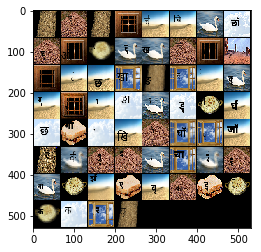

V7 C9
V5 C6
V8 C0
V4 C6
V3 C6
V2 C4
V8 C3
V9 C7
V6 C4
V9 C0
V7 C7
V6 C7
V0 C2
V0 C5
V4 C6
V5 C1
V4 C0
V7 C1
V0 C7
V1 C2
V0 C5
V8 C2
V8 C5
V6 C1
V5 C3
V7 C4
V8 C4
V1 C5
V7 C7
V6 C5
V0 C8
V3 C4
V0 C7
V1 C3
V8 C6
V2 C2
V5 C4
V9 C4
V5 C6
V9 C8
V8 C8
V3 C1
V4 C5
V6 C9
V7 C3
V1 C6
V7 C5
V7 C7
V1 C3
V8 C1
V3 C9
V7 C0
V6 C1
V1 C1
V4 C9
V8 C9
V0 C1
V0 C1
V7 C8
V6 C1


In [60]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()
print(type(labels))
print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(torchvision.utils.make_grid(images))
def labelshow(labels):
    
    for label in labels:
        x=label.cpu().detach().numpy()
        #print(x[0])
        z=x[0]
        for i in range(x.shape[1]):
            if z[i]==1:
              #  print(i)
                l1=list(classes)[i+10]
                break
        z=x[1]
        for i in range(x.shape[1]):
            if z[i] == 1:
                l2=list(classes)[i]
                break
        print(l1,l2)
labelshow(torchvision.utils.make_grid(labels))





In [0]:
from torchvision import models

In [0]:
import re
import torch
import torch.nn as nn
import torch.nn.functional as F


from collections import OrderedDict

__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']

model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,
                                bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate,
                                drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        out= F.sigmoid(out,inplace=True)
        return out


def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = torch.hub.load_state_dict_from_url(model_url)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)



def densenet161(pretrained=False, progress=True, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)



def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)



def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)


In [35]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [36]:
model2 = models.resnet18(pretrained=True)
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for param in model.parameters():
    param.requires_grad = False


In [0]:
for param in model2.parameters():
    param.requires_grad = False

In [0]:
import torch.nn as nn
final_in_features = model2.fc.in_features
model2.fc=nn.Linear(final_in_features, 10)

import torch.nn as nn
final_in_features = model.fc.in_features
model.fc=nn.Linear(final_in_features, 10)





In [0]:
def make_one_hot(labels, C=10):
  batch_size=labels.shape[0]
  c=labels.shape[1]
  for x in range(batch_size):
    values, indices = torch.max(labels[x],0)
    labels[x,indices:indices+1]=1.0
    for y in range(c):
      if indices!=y:
         labels[x,y:y+1]=0.0
  return labels
   

In [0]:
def evaluation(dataloader,model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs1 = model(inputs)
        outputs2 = model2(inputs)
        outputs1=make_one_hot(outputs1)
        outputs2=make_one_hot(outputs2)      
        l1=labels[:, 0, :]
        l2=labels[:,1,:]
        total += labels.size(0)
        for x in range(outputs1.shape[0]):
          if torch.equal(l1[x],outputs1[x]) and torch.equal(l2[x],outputs2[x]) :
            correct =correct+1
    return 100 * correct / total

In [42]:
for param in model.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [43]:
for param in model2.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [44]:
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
model= model.to(device)
model2= model2.to(device)
criterion = nn.BCELoss()
criterion2 = nn.BCELoss()
lr=0.1
opt  = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)

opt2 =  torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
scheduler1 = StepLR(opt, step_size=1, gamma=0.1)
scheduler2 = StepLR(opt2, step_size=1, gamma=0.1)

cuda:0


In [45]:
ls

sample_data/  sample_submission.csv  test/  test.zip  train/  train.zip


In [73]:
import copy
loss_epoch_arr = []


min_loss = 1000

n_iters = 700
max_epochs =5
for epoch in range(max_epochs):
    scheduler1.step()
    scheduler2.step()
    print(enumerate(train_loader, 0))
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
       
       
        inputs, labels = inputs.to(device), labels.to(device)
      
      #  inputs, labels = inputs,labels
        opt.zero_grad()

        outputs1 = model(inputs)
        #print(outputs1[0])
        outputs2 = model2(inputs)
      
       # print(outputs1[0])
        outputs1=make_one_hot(outputs1)
        outputs2=make_one_hot(outputs2)
          
        l1=labels[:, 0, :]
        l2=labels[:,1,:]
        #print(outputs1[0])
       # print(l1[0])
        
        loss1 = criterion(outputs1,l1)
        loss2 = criterion2(outputs2,l2)
        loss1.backward()
        loss2.backward()
        opt.step()
        opt2.step()
        
        if min_loss > loss1.item():
            min_loss = loss1.item()
            best_model1 = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)
        if min_loss > loss2.item():
            min_loss2 = loss2.item()
            best_model2 = copy.deepcopy(model2.state_dict())
            print('Min loss %0.2f' % min_loss2)
        
        
        if i % 100 == 0:
            print('model1: Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss1.item()))
            print('model2: Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss2.item()))
            
        del inputs, labels,l1,l2, outputs1, outputs2
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss1.item())
    loss_epoch_arr.append(loss2.item())

        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f,'% (
        epoch, max_epochs, 
        evaluation(validation_loader, model), evaluation(train_loader, model)))
    print('lr : ',scheduler1.get_lr())
    
plt.plot(loss_epoch_arr)
plt.show()

AttributeError: ignored

In [0]:
def submission(model,model2,dataloader):
    labelsx=[]
    
    for i, data in enumerate(dataloader, 0):
        print(type(data))
        i, inputs = data
        inputs = i.to(device)
        outputs1 = model(inputs)
        outputs2 = model2(inputs)
        outputs1=make_one_hot(outputs1)
        outputs2=make_one_hot(outputs2)
        x= outputs1.cpu().detach().numpy()
        y= outputs2.cpu().detach().numpy()
        
        z=x[0]
        print(z)
        for i in range(x.shape[1]):
            if z[i]==1:
              #  print(i)
                l1=list(classes)[i+10]
                break
        z=y[0]
        for i in range(x.shape[1]):
            if z[i] == 1:
                l2=list(classes)[i]
                break
              
     #   plt.imshow(inputs.cpu().numpy().reshape(28,28))
     #   plt.show()
        z=l1+'_'+l2
        #print(x)
        labelsx.append(z)
    results = pd.Series(labelsx,name="Class")
    submission = pd.concat([pd.Series(range(1,10001),name = "ImageId"),results],axis = 1)

    submission.to_csv("sub.csv",index=False)
    

In [84]:
print(type(test_loader))
submission(model,model2,test_loader)

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'list'>
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'list'>
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
<class 'lis